In [0]:
import os
import sys
import time
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

In [0]:
def stylize(model, img, size):
    style_model = TransformerNet()
    state_dict = torch.load(model)
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device);   
    
    with torch.no_grad():
        output = style_model(img)

    img = output[0].cpu().clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    if size is not None: return Image.fromarray(img).resize((size, size), Image.ANTIALIAS)
    else: return Image.fromarray(img)

In [0]:
seed = 10
image_size = 256
dataset = "/content/drive/My Drive/coco"
batch_size = 8
lr = 3e-4
style_image = "/content/starry.jpg"
style_size = image_size
epochs = 1
content_weight = 1e5
style_weight = 3e9
log_interval = 125
checkpoint_interval = 2000
save_model_dir = "/content"
device = torch.device("cuda")

In [0]:
np.random.seed(seed)
torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [0]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8])


In [0]:
len(train_loader)

3125

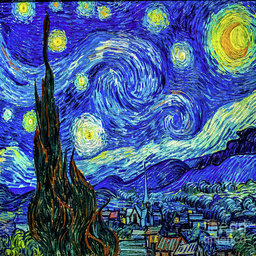

In [0]:
style = utils.load_image(style_image, size=style_size)
style

In [0]:
vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)
style.shape

torch.Size([8, 3, 256, 256])

In [0]:
transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), lr)
mse_loss = torch.nn.MSELoss()

In [0]:
features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

In [0]:
content = []
style = []

iteration = 0
since = time.time()
for e in range(epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight

        total_loss = content_loss + style_loss
        style.append(float(style_loss.cpu().detach().numpy()))
        content.append(float(content_loss.cpu().detach().numpy()))
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % log_interval == 0:
            time_elapsed = time.time() - since
            mesg = "Epoch {} in {:.0f}m {:.0f}s:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                e + 1, time_elapsed // 60, time_elapsed % 60, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)

# save model
transformer.eval().cpu()
save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    content_weight) + "_" + str(style_weight) + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)

Epoch 1 in 8m 1s:	[1000/25000]	content: 960546.488500	style: 9924985.532000	total: 10885532.020500
Epoch 1 in 16m 43s:	[2000/25000]	content: 1148671.323750	style: 7144849.543000	total: 8293520.866750
Epoch 1 in 24m 37s:	[3000/25000]	content: 1251515.623833	style: 5612255.924333	total: 6863771.548167
Epoch 1 in 32m 34s:	[4000/25000]	content: 1312877.097375	style: 4618999.270250	total: 5931876.367625
Epoch 1 in 40m 28s:	[5000/25000]	content: 1350489.688500	style: 3924408.704100	total: 5274898.392600
Epoch 1 in 48m 26s:	[6000/25000]	content: 1372934.266917	style: 3412673.747833	total: 4785608.014750
Epoch 1 in 56m 23s:	[7000/25000]	content: 1386733.315357	style: 3021337.990714	total: 4408071.306071
Epoch 1 in 64m 26s:	[8000/25000]	content: 1394961.479813	style: 2712816.112781	total: 4107777.592594
Epoch 1 in 72m 29s:	[9000/25000]	content: 1399383.820611	style: 2465153.473528	total: 3864537.294139
Epoch 1 in 80m 34s:	[10000/25000]	content: 1400421.169750	style: 2262288.486225	total: 366270

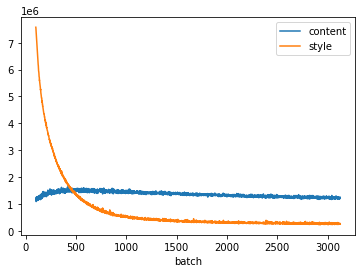

In [0]:
df = pd.DataFrame({'batch': np.arange(len(style)), 'content': content, 'style': style})
df[100:].plot(x='batch', y=['content', 'style'])
plt.show()

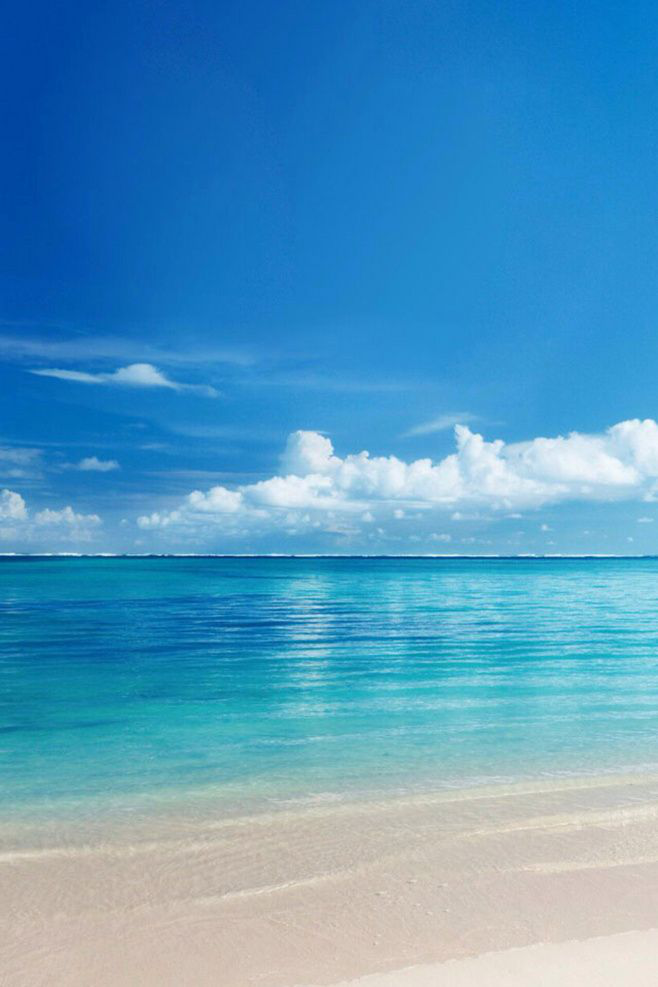

In [0]:
content_image = utils.load_image("beach.jpg")
content_image

In [0]:
content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

content_image = content_transform(content_image)

content_image = content_image.unsqueeze(0).to(device)
content_image.shape

torch.Size([1, 3, 987, 658])

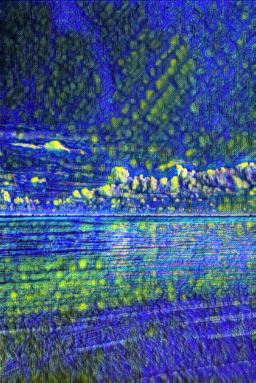

In [0]:
st = stylize("/content/epoch_1_Sun_Jun__7_08:23:59_2020_100000.0_3000000000.0.model", content_image, None)
st = transforms.Resize(256)(st)
st